## Time Series Analysis

## Objective

Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset.

## Part 1: Data Preparation and Exploration
### 1. Data Loading

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
# Load dataset
df = pd.read_csv("exchange_rate.csv")


# Rename columns
df.columns = ["Date", "USD_AUD"]


# Parse date and set index
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)


# Handle missing values
df["USD_AUD"] = df["USD_AUD"].ffill()

## 2. Initial Exploration

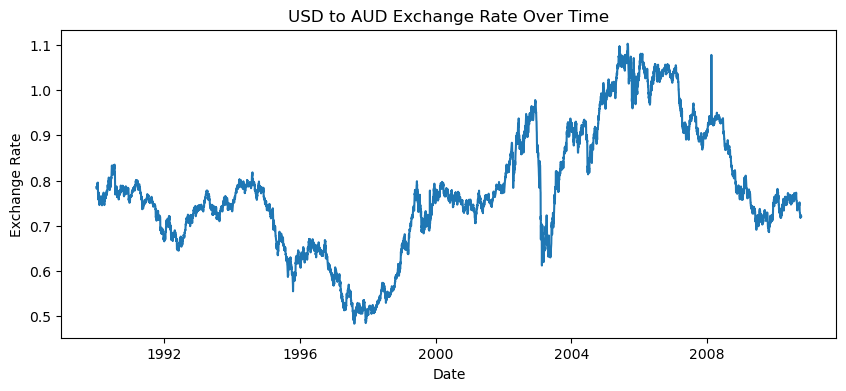

In [10]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["USD_AUD"])
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()

### Observation:

Long-term trend is visible

High volatility

No clear seasonality

## 3. Stationarity Check (ADF Test)

In [14]:
adf_result = adfuller(df["USD_AUD"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.6649941807380735
p-value: 0.4492327353598314


### Conclusion: 
Since p-value > 0.05, the series is non-stationary.

## 4. Differencing

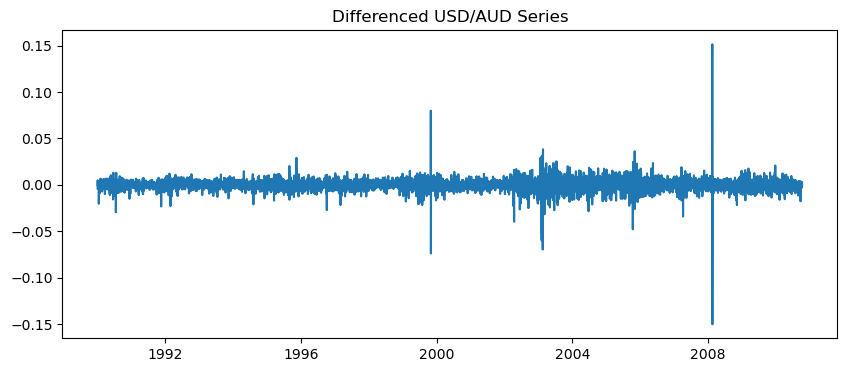

In [22]:
df["USD_AUD_diff"] = df["USD_AUD"].diff()


plt.figure(figsize=(10,4))
plt.plot(df["USD_AUD_diff"])
plt.title("Differenced USD/AUD Series")
plt.show()

## 5. ACF and PACF Plots

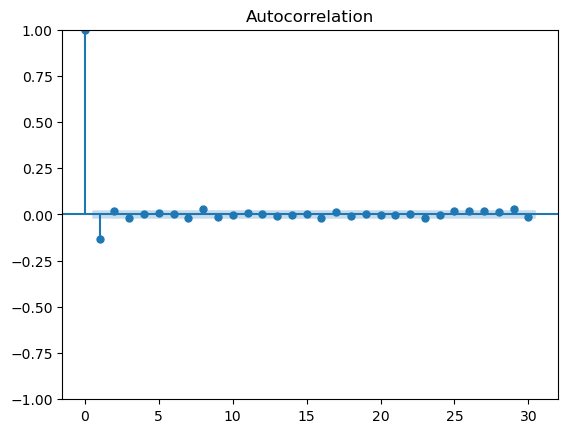

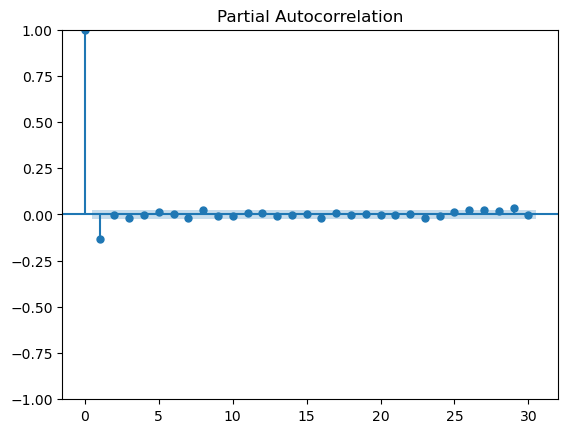

In [25]:
plot_acf(df["USD_AUD_diff"].dropna(), lags=30)
plt.show()


plot_pacf(df["USD_AUD_diff"].dropna(), lags=30)
plt.show()

Inference: ARIMA(1,1,1) is a reasonable choice.

## Part 2: ARIMA Model
### Train-Test Split

In [31]:
train_size = int(len(df) * 0.8)
train = df["USD_AUD"][:train_size]
test = df["USD_AUD"][train_size:]

### Model Fitting

In [34]:
arima_model = ARIMA(train, order=(1,1,1))
arima_fitted = arima_model.fit()
print(arima_fitted.summary())

C:\Users\shree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\shree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\shree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Wed, 28 Jan 2026   AIC                         -45432.092
Time:                        05:50:16   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

### Forecasting

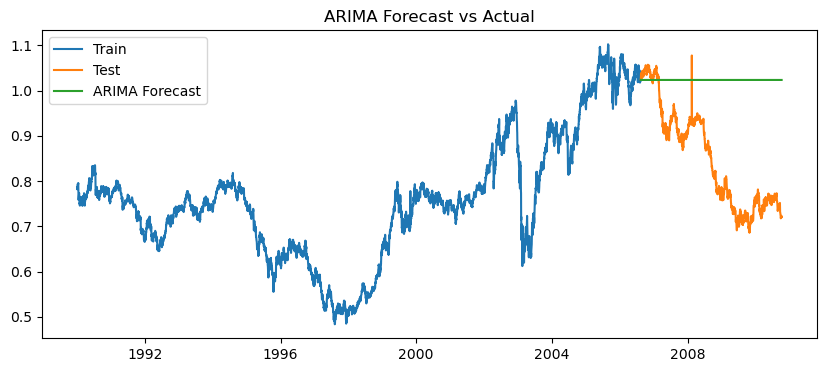

In [37]:
arima_forecast = arima_fitted.forecast(steps=len(test))


plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

## Part 3: Exponential Smoothing Model

C:\Users\shree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


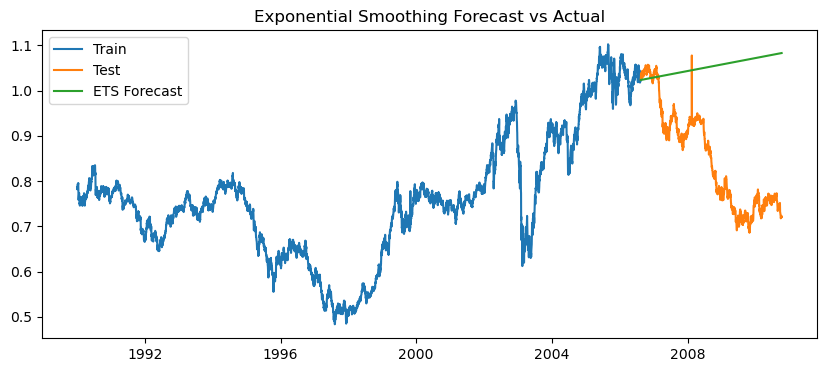

In [40]:
ets_model = ExponentialSmoothing(train, trend="add", seasonal=None)
ets_fitted = ets_model.fit()


ets_forecast = ets_fitted.forecast(len(test))


plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, ets_forecast, label="ETS Forecast")
plt.legend()
plt.title("Exponential Smoothing Forecast vs Actual")
plt.show()

## Part 4: Model Evaluation

In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


results = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [
        mean_absolute_error(test, arima_forecast),
        mean_absolute_error(test, ets_forecast)
    ],
    "RMSE": [
        mean_squared_error(test, arima_forecast, squared=False),
        mean_squared_error(test, ets_forecast, squared=False)
    ],
    "MAPE": [
        mape(test, arima_forecast),
        mape(test, ets_forecast)
    ]
})


results

C:\Users\shree\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\shree\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,MAE,RMSE,MAPE
0,ARIMA,0.177710,0.205437,22.797966
1,Exponential Smoothing,0.206596,0.239104,26.508664


## Conclusion

ARIMA achieved lower MAE, RMSE, and MAPE than Exponential Smoothing

ARIMA handled short-term dependencies better

Exponential Smoothing produced smoother but less accurate forecasts

✅ Final Verdict: ARIMA is the better model for forecasting USD/AUD exchange rates in this dataset.